In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
# from Model_2D_RCAN import make_generator

from loss_2D import generator_loss
from skimage import exposure
from skimage.exposure import match_histograms
from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [2]:
patch_size = 256
n_patches =  1
n_channel =  0
augment = True
shuffle = True 
batch_size = 1
add_noise= True
lp = 0.5

GT_image_dr = r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\npcomplex-golgi\golgi\patches\Average\Average.tif'
lowSNR_image_dr =r'D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\npcomplex-golgi\golgi\patches\1frame\1frame.tif'

x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 0,ratio=1.0,lp=lp, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(224, 1, 256, 256)
896
The training set shape is: (896, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


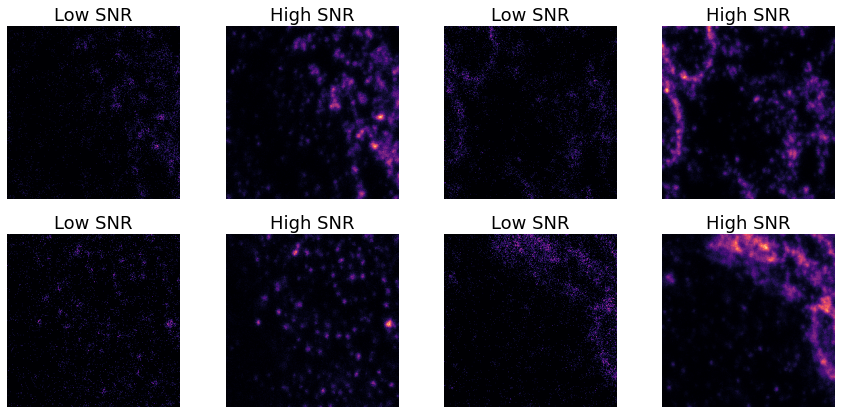

In [3]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [4]:
model_save_directory = r"D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\npcomplex-golgi\golgi\golgi.h5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 


n_epochs =  400
gen_lr = 1e-4

filters =[32,64,128]
# filters =[80,160]
num_filters = filters[0]
# filters_cab=num_filters/8
filters_cab=num_filters/16

num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
# generator.load_weights(load_model_save_directory)



lr_max = 1e-4
lr_min = 1e-6
T = 40
a1 = 0.7
a2 = 0.7
def scheduler(epoch, lr):
    lr_min_i = a1**np.floor((epoch)/T)*lr_min
    lr_max_i = a2**np.floor((epoch)/T)*lr_max
    lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
    return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

# lr_max = 1e-4
# lr_min = 1e-6
# a1 = 0.5
# T = 20
# def scheduler(epoch, lr):
#     if lr>lr_min:
#         lr = gen_lr*(a1**np.floor((epoch+1)/T))
#     else:
#         lr = lr_min
#     return lr

callbacks = [
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [
#     EarlyStopping(patience=30, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [5]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/400
806/806 [==============================] - ETA: 0s - loss: 0.2431 - conv2d_36_loss: 0.1259 - add_39_loss: 0.1173
Epoch 00001: val_loss improved from inf to 0.21175, saving model to D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\npcomplex-golgi\golgi\golgi.h5
806/806 [==============================] - 68s 75ms/step - loss: 0.2431 - conv2d_36_loss: 0.1259 - add_39_loss: 0.1173 - val_loss: 0.2117 - val_conv2d_36_loss: 0.1060 - val_add_39_loss: 0.1058 - lr: 1.0000e-04
Epoch 2/400
806/806 [==============================] - ETA: 0s - loss: 0.2192 - conv2d_36_loss: 0.1128 - add_39_loss: 0.1064
Epoch 00002: val_loss improved from 0.21175 to 0.21081, saving model to D:\Projects\Denosing-STED-Abberior\2022-11-03_UCF_DemoSamples\npcomplex-golgi\golgi\golgi.h5
806/806 [==============================] - 60s 74ms/step - loss: 0.2192 - conv2d_36_loss: 0.1128 - add_39_loss: 0.1064 - val_loss: 0.2108 - val_conv2d_36_loss: 0.1055 - val_add_39_loss: 0.1053 - lr: 9.9839e-05
Epoc

Epoch 21/400
806/806 [==============================] - ETA: 0s - loss: 0.2025 - conv2d_36_loss: 0.1014 - add_39_loss: 0.1011
Epoch 00021: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.2025 - conv2d_36_loss: 0.1014 - add_39_loss: 0.1011 - val_loss: 0.2081 - val_conv2d_36_loss: 0.1043 - val_add_39_loss: 0.1037 - lr: 4.8507e-05
Epoch 22/400
806/806 [==============================] - ETA: 0s - loss: 0.2020 - conv2d_36_loss: 0.1012 - add_39_loss: 0.1009
Epoch 00022: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - loss: 0.2020 - conv2d_36_loss: 0.1012 - add_39_loss: 0.1009 - val_loss: 0.2120 - val_conv2d_36_loss: 0.1063 - val_add_39_loss: 0.1057 - lr: 4.4533e-05
Epoch 23/400
806/806 [==============================] - ETA: 0s - loss: 0.2017 - conv2d_36_loss: 0.1010 - add_39_loss: 0.1007
Epoch 00023: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74

806/806 [==============================] - ETA: 0s - loss: 0.2004 - conv2d_36_loss: 0.1003 - add_39_loss: 0.1001
Epoch 00042: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - loss: 0.2004 - conv2d_36_loss: 0.1003 - add_39_loss: 0.1001 - val_loss: 0.2072 - val_conv2d_36_loss: 0.1039 - val_add_39_loss: 0.1033 - lr: 6.9888e-05
Epoch 43/400
806/806 [==============================] - ETA: 0s - loss: 0.2002 - conv2d_36_loss: 0.1002 - add_39_loss: 0.1000
Epoch 00043: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.2002 - conv2d_36_loss: 0.1002 - add_39_loss: 0.1000 - val_loss: 0.2090 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1041 - lr: 6.9551e-05
Epoch 44/400
806/806 [==============================] - ETA: 0s - loss: 0.1999 - conv2d_36_loss: 0.1001 - add_39_loss: 0.0998
Epoch 00044: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - los

806/806 [==============================] - ETA: 0s - loss: 0.1945 - conv2d_36_loss: 0.0974 - add_39_loss: 0.0971
Epoch 00063: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1945 - conv2d_36_loss: 0.0974 - add_39_loss: 0.0971 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 2.8419e-05
Epoch 64/400
806/806 [==============================] - ETA: 0s - loss: 0.1943 - conv2d_36_loss: 0.0973 - add_39_loss: 0.0970
Epoch 00064: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1943 - conv2d_36_loss: 0.0973 - add_39_loss: 0.0970 - val_loss: 0.2108 - val_conv2d_36_loss: 0.1055 - val_add_39_loss: 0.1053 - lr: 2.5710e-05
Epoch 65/400
806/806 [==============================] - ETA: 0s - loss: 0.1941 - conv2d_36_loss: 0.0972 - add_39_loss: 0.0969
Epoch 00065: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - los

806/806 [==============================] - ETA: 0s - loss: 0.1940 - conv2d_36_loss: 0.0972 - add_39_loss: 0.0969
Epoch 00084: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1940 - conv2d_36_loss: 0.0972 - add_39_loss: 0.0969 - val_loss: 0.2088 - val_conv2d_36_loss: 0.1045 - val_add_39_loss: 0.1042 - lr: 4.8295e-05
Epoch 85/400
806/806 [==============================] - ETA: 0s - loss: 0.1941 - conv2d_36_loss: 0.0972 - add_39_loss: 0.0969
Epoch 00085: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 75ms/step - loss: 0.1941 - conv2d_36_loss: 0.0972 - add_39_loss: 0.0969 - val_loss: 0.2108 - val_conv2d_36_loss: 0.1055 - val_add_39_loss: 0.1053 - lr: 4.7752e-05
Epoch 86/400
806/806 [==============================] - ETA: 0s - loss: 0.1939 - conv2d_36_loss: 0.0971 - add_39_loss: 0.0968
Epoch 00086: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - los

806/806 [==============================] - ETA: 0s - loss: 0.1907 - conv2d_36_loss: 0.0956 - add_39_loss: 0.0952
Epoch 00105: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 75ms/step - loss: 0.1907 - conv2d_36_loss: 0.0956 - add_39_loss: 0.0952 - val_loss: 0.2093 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 1.6144e-05
Epoch 106/400
806/806 [==============================] - ETA: 0s - loss: 0.1906 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0951
Epoch 00106: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1906 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0951 - val_loss: 0.2086 - val_conv2d_36_loss: 0.1045 - val_add_39_loss: 0.1041 - lr: 1.4347e-05
Epoch 107/400
806/806 [==============================] - ETA: 0s - loss: 0.1905 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0950
Epoch 00107: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1908 - conv2d_36_loss: 0.0956 - add_39_loss: 0.0952
Epoch 00126: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1908 - conv2d_36_loss: 0.0956 - add_39_loss: 0.0952 - val_loss: 0.2093 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 3.2941e-05
Epoch 127/400
806/806 [==============================] - ETA: 0s - loss: 0.1906 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0951
Epoch 00127: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1906 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0951 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1045 - lr: 3.2355e-05
Epoch 128/400
806/806 [==============================] - ETA: 0s - loss: 0.1906 - conv2d_36_loss: 0.0955 - add_39_loss: 0.0951
Epoch 00128: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 73ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1887 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0941
Epoch 00147: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1887 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0941 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 8.8323e-06
Epoch 148/400
806/806 [==============================] - ETA: 0s - loss: 0.1887 - conv2d_36_loss: 0.0945 - add_39_loss: 0.0941
Epoch 00148: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1887 - conv2d_36_loss: 0.0945 - add_39_loss: 0.0941 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1046 - lr: 7.6766e-06
Epoch 149/400
806/806 [==============================] - ETA: 0s - loss: 0.1886 - conv2d_36_loss: 0.0945 - add_39_loss: 0.0940
Epoch 00149: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1888 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0942
Epoch 00168: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1888 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0942 - val_loss: 0.2093 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 2.2170e-05
Epoch 169/400
806/806 [==============================] - ETA: 0s - loss: 0.1887 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0941
Epoch 00169: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 75ms/step - loss: 0.1887 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0941 - val_loss: 0.2092 - val_conv2d_36_loss: 0.1047 - val_add_39_loss: 0.1045 - lr: 2.1626e-05
Epoch 170/400
806/806 [==============================] - ETA: 0s - loss: 0.1886 - conv2d_36_loss: 0.0946 - add_39_loss: 0.0941
Epoch 00170: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935
Epoch 00189: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935 - val_loss: 0.2095 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1046 - lr: 4.6085e-06
Epoch 190/400
806/806 [==============================] - ETA: 0s - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935
Epoch 00190: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935 - val_loss: 0.2092 - val_conv2d_36_loss: 0.1047 - val_add_39_loss: 0.1044 - lr: 3.8921e-06
Epoch 191/400
806/806 [==============================] - ETA: 0s - loss: 0.1874 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935
Epoch 00191: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1876 - conv2d_36_loss: 0.0941 - add_39_loss: 0.0936
Epoch 00210: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1876 - conv2d_36_loss: 0.0941 - add_39_loss: 0.0936 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 1.4715e-05
Epoch 211/400
806/806 [==============================] - ETA: 0s - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935
Epoch 00211: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935 - val_loss: 0.2093 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1045 - lr: 1.4251e-05
Epoch 212/400
806/806 [==============================] - ETA: 0s - loss: 0.1875 - conv2d_36_loss: 0.0940 - add_39_loss: 0.0935
Epoch 00212: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 75ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931
Epoch 00231: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1046 - lr: 2.2603e-06
Epoch 232/400
806/806 [==============================] - ETA: 0s - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931
Epoch 00232: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1046 - lr: 1.8366e-06
Epoch 233/400
806/806 [==============================] - ETA: 0s - loss: 0.1867 - conv2d_36_loss: 0.0936 - add_39_loss: 0.0931
Epoch 00233: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931
Epoch 00252: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 9.6244e-06
Epoch 253/400
806/806 [==============================] - ETA: 0s - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931
Epoch 00253: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1868 - conv2d_36_loss: 0.0937 - add_39_loss: 0.0931 - val_loss: 0.2094 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1046 - lr: 9.2495e-06
Epoch 254/400
806/806 [==============================] - ETA: 0s - loss: 0.1867 - conv2d_36_loss: 0.0936 - add_39_loss: 0.0931
Epoch 00254: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 73ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928
Epoch 00273: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928 - val_loss: 0.2096 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 1.0192e-06
Epoch 274/400
806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928
Epoch 00274: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928 - val_loss: 0.2096 - val_conv2d_36_loss: 0.1048 - val_add_39_loss: 0.1047 - lr: 7.8471e-07
Epoch 275/400
806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928
Epoch 00275: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0929
Epoch 00294: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 73ms/step - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0929 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 6.1972e-06
Epoch 295/400
806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0929
Epoch 00295: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0929 - val_loss: 0.2096 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1047 - lr: 5.9065e-06
Epoch 296/400
806/806 [==============================] - ETA: 0s - loss: 0.1863 - conv2d_36_loss: 0.0934 - add_39_loss: 0.0928
Epoch 00296: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 75ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927
Epoch 00315: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 75ms/step - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 4.0856e-07
Epoch 316/400
806/806 [==============================] - ETA: 0s - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927
Epoch 00316: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 2.9215e-07
Epoch 317/400
806/806 [==============================] - ETA: 0s - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927
Epoch 00317: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927
Epoch 00336: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927 - val_loss: 0.2097 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1048 - lr: 3.9231e-06
Epoch 337/400
806/806 [==============================] - ETA: 0s - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927
Epoch 00337: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1860 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0927 - val_loss: 0.2099 - val_conv2d_36_loss: 0.1050 - val_add_39_loss: 0.1049 - lr: 3.7051e-06
Epoch 338/400
806/806 [==============================] - ETA: 0s - loss: 0.1859 - conv2d_36_loss: 0.0933 - add_39_loss: 0.0926
Epoch 00338: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1858 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0926
Epoch 00357: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1858 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0926 - val_loss: 0.2098 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 1.4057e-07
Epoch 358/400
806/806 [==============================] - ETA: 0s - loss: 0.1858 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0926
Epoch 00358: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - loss: 0.1858 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0926 - val_loss: 0.2098 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 9.4601e-08
Epoch 359/400
806/806 [==============================] - ETA: 0s - loss: 0.1858 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0926
Epoch 00359: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1857 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0925
Epoch 00378: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1857 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0925 - val_loss: 0.2099 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 2.4374e-06
Epoch 379/400
806/806 [==============================] - ETA: 0s - loss: 0.1857 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0925
Epoch 00379: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 74ms/step - loss: 0.1857 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0925 - val_loss: 0.2098 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 2.2786e-06
Epoch 380/400
806/806 [==============================] - ETA: 0s - loss: 0.1857 - conv2d_36_loss: 0.0932 - add_39_loss: 0.0925
Epoch 00380: val_loss did not improve from 0.20631
806/806 [==============================] - 59s 74ms/step - l

806/806 [==============================] - ETA: 0s - loss: 0.1856 - conv2d_36_loss: 0.0931 - add_39_loss: 0.0925
Epoch 00399: val_loss did not improve from 0.20631
806/806 [==============================] - 60s 75ms/step - loss: 0.1856 - conv2d_36_loss: 0.0931 - add_39_loss: 0.0925 - val_loss: 0.2098 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 4.6831e-08
Epoch 400/400
806/806 [==============================] - ETA: 0s - loss: 0.1856 - conv2d_36_loss: 0.0931 - add_39_loss: 0.0925
Epoch 00400: val_loss did not improve from 0.20631
806/806 [==============================] - 61s 76ms/step - loss: 0.1856 - conv2d_36_loss: 0.0931 - add_39_loss: 0.0925 - val_loss: 0.2098 - val_conv2d_36_loss: 0.1049 - val_add_39_loss: 0.1049 - lr: 4.0354e-08
